In [269]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

### MrCool 3 ton unit

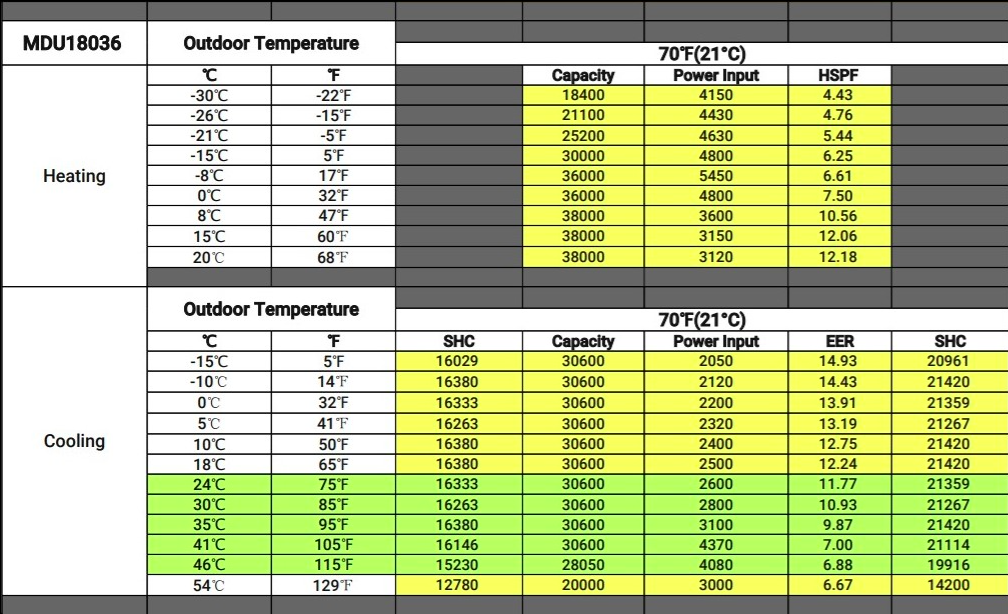

In [503]:
mrcool_specs_3_ton = [     
    [-30, 18400, 4150],
    [-26, 21100, 4430],
    [-21, 25200, 4630],
    [-15, 30000, 4800],
    [-8, 36000, 5450],
    [0, 36000, 4800],
    [8, 38000, 3600],
    [15, 38000, 3150],
    [20, 38000, 3120]
]

mrcool_specs_5_ton = [     
    [-30, 27000, 6350],
    [-26, 32000, 6700],
    [-21, 37000, 7000],
    [-15, 44000, 7160],
    [-8, 49000, 7100],
    [0, 54000, 6600],
    [8, 56000, 5300],
    [15, 60000, 5400],
    [20, 60000, 5100]
]

# numpy.interp(x, xp, fp, left=None, right=None, period=None)

btuph_to_w = 0.000293071 * 1000.

mrcool_specs = mrcool_specs_3_ton

def mrcool_heat_output(t_out):
    h_out_btuph = np.interp(t_out, [x[0] for x in mrcool_specs], [x[1] for x in mrcool_specs])
    h_out_w = btuph_to_w * h_out_btuph
    return round(h_out_w, 1)

def mrcool_power_consumption(t_out):
    power_consumption_w = np.interp(t_out, [x[0] for x in mrcool_specs], [x[2] for x in mrcool_specs])
    return power_consumption_w

def electricity_cost(hour_of_day, day_of_week):
    # https://www.hydroone.com/rates-and-billing/rates-and-charges/electricity-pricing-and-costs
    
    off_peak = 8.2
    mid_peak = 11.3
    on_peak = 17.0
    
    if day_of_week in (5, 6):
        # weekend
        return off_peak
    
    if hour_of_day < 7 or hour_of_day > 19:
        return off_peak
    
    if hour_of_day > 11 and hour_of_day < 17:
        return mid_peak
    
    return on_peak

In [504]:
kwargs = {"header": 4, "index_col": False}
ecobee = pd.concat([
    pd.read_csv("ecobee_data/2021-09.csv", **kwargs),
    pd.read_csv("ecobee_data/2021-10.csv", **kwargs),
    pd.read_csv("ecobee_data/2021-11.csv", **kwargs),
    pd.read_csv("ecobee_data/2021-12.csv", **kwargs),
    pd.read_csv("ecobee_data/2022-01.csv", **kwargs),
    pd.read_csv("ecobee_data/2022-02.csv", **kwargs),
    pd.read_csv("ecobee_data/2022-03-partial.csv", **kwargs)
])


In [505]:
ecobee.columns

Index(['Date', 'Time', 'System Setting', 'System Mode', 'Calendar Event',
       'Program Mode', 'Cool Set Temp (C)', 'Heat Set Temp (C)',
       'Current Temp (C)', 'Current Humidity (%RH)', 'Outdoor Temp (C)',
       'Wind Speed (km/h)', 'Cool Stage 1 (sec)', 'Heat Stage 1 (sec)',
       'Fan (sec)', 'DM Offset', 'Thermostat Temperature (C)',
       'Thermostat Humidity (%RH)', 'Thermostat Motion', 'Upstairs (C)',
       'Upstairs2', 'Basement (C)', 'Basement2'],
      dtype='object')

In [506]:
ecobee["datetime"] = pd.to_datetime(ecobee["Date"] + "T" + ecobee["Time"])

In [507]:
cols_of_interest = [
    "datetime",
    "System Setting",
    "System Mode",
    "Heat Set Temp (C)",
    'Outdoor Temp (C)',
    "Thermostat Temperature (C)",
    'Heat Stage 1 (sec)'
]
col_dict = {
    "System Setting": "system_setting", 
    "System Mode": "system_mode", 
    "Calendar Event": "calendar_event",
    "Outdoor Temp (C)": "outdoor_temp_c",
    "Thermostat Temperature (C)": "indoor_temp_c",
    "Heat Stage 1 (sec)": "heat_1_sec",
    'Heat Set Temp (C)': "heat_setpoint_c"
}



In [508]:
ecobee = ecobee[cols_of_interest].copy()
ecobee.set_index("datetime", inplace=True)
ecobee.rename(columns=col_dict, inplace=True)

In [509]:
ecobee.head()

,system_setting,system_mode,heat_setpoint_c,outdoor_temp_c,indoor_temp_c,heat_1_sec
datetime,,,,,,
2021-09-01 00:00:00,off,heatOff,19.5,16.3,21.3,0.0
2021-09-01 00:05:00,off,heatOff,19.5,16.3,21.3,0.0
2021-09-01 00:10:00,off,heatOff,19.5,16.3,21.3,0.0
2021-09-01 00:15:00,off,heatOff,19.5,16.3,21.3,0.0
2021-09-01 00:20:00,off,heatOff,19.5,16.3,21.3,0.0


In [510]:
ecobee["dt_c"] = ecobee["indoor_temp_c"] - ecobee["outdoor_temp_c"]

In [511]:
heating_data = ecobee.query("system_setting == 'heat'").copy()

In [512]:
agg_fns = {"outdoor_temp_c": np.nanmean, "dt_c": np.nanmean, "heat_1_sec": np.nansum, "system_setting": len}
df_h = heating_data.groupby(pd.Grouper(freq="H")).aggregate(agg_fns)
df_h.rename(columns={"system_setting": "data_count"}, inplace=True)

In [513]:
df_h = df_h.query("data_count == 12").copy() # throw out incomplete data

In [514]:
df_h["runtime_fraction"] = df_h["heat_1_sec"]/(60.*60.)

In [515]:
furnace_output_btuph = 62000
df_h["heat_load_w"] = df_h["runtime_fraction"] * furnace_output_btuph * btuph_to_w

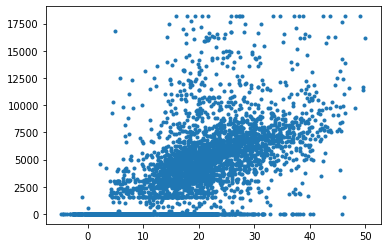

In [516]:
x_data = df_h["dt_c"]
y_data = df_h["heat_load_w"]
plt.plot(x_data, y_data, '.')

In [517]:
increment = 0.5
_temp_range = np.arange(0, 50, increment)
temp_range = []

mean_load_w_array = []
for t in _temp_range:
    t1 = t - increment/2.
    t2 = t + increment/2.
    mean_load_w = df_h.query("dt_c >= @t1 and dt_c < @t2")["heat_load_w"].mean()  
    if mean_load_w == mean_load_w:
        # filter out nan, if no t_out exists
        temp_range.append(t1)
        mean_load_w_array.append(mean_load_w)


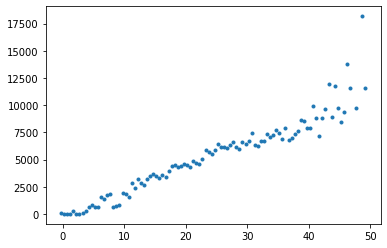

In [518]:
plt.plot(temp_range, mean_load_w_array, '.')

In [519]:
stats.linregress(temp_range, np.array(mean_load_w_array))


LinregressResult(slope=235.73481748003354, intercept=-375.7628019401809, rvalue=0.9549419020546095, pvalue=1.926600116396577e-52, stderr=7.477639431269892, intercept_stderr=208.64178975088453)

In [520]:
stats.linregress(temp_range, np.array(mean_load_w_array))


LinregressResult(slope=235.73481748003354, intercept=-375.7628019401809, rvalue=0.9549419020546095, pvalue=1.926600116396577e-52, stderr=7.477639431269892, intercept_stderr=208.64178975088453)

In [521]:
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_range, mean_load_w_array)


def get_load_w(dt_c):
    y = slope * dt_c + intercept
    return y

calc_y_data = [get_load_w(x) for x in temp_range]

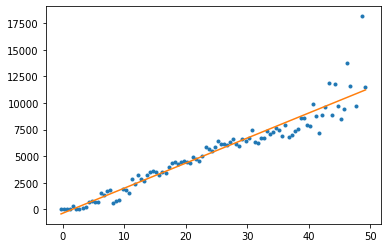

In [522]:
plt.plot(
    temp_range, mean_load_w_array, '.',
    temp_range, calc_y_data, '-'
)

Estimate the cost

In [523]:
agg_fns = {"outdoor_temp_c": np.nanmean, "dt_c": np.nanmean}
df_h_sim = heating_data.groupby(pd.Grouper(freq="H")).aggregate(agg_fns)


In [524]:
df_h_sim = df_h_sim.query("outdoor_temp_c == outdoor_temp_c and dt_c == dt_c").copy()

In [525]:
df_h_sim["modelled_load_w"] = df_h_sim["dt_c"].map(get_load_w)

In [526]:
df_h_sim["heat_pump_max_out_w"] = df_h_sim["outdoor_temp_c"].map(mrcool_heat_output)

In [527]:
df_h_sim["cop"] = df_h_sim["heat_pump_max_out_w"] / df_h_sim["outdoor_temp_c"].map(mrcool_power_consumption)

In [528]:
def out_fn(x):
    if x["heat_pump_max_out_w"] >= x["modelled_load_w"]:
        return x["modelled_load_w"]
    return x["heat_pump_max_out_w"]

df_h_sim["heat_pump_out_w"] = df_h_sim.apply(out_fn, axis=1)

In [529]:
df_h_sim["aux_out_w"] = df_h_sim["modelled_load_w"] - df_h_sim["heat_pump_out_w"]

In [530]:
df_h_sim["heat_pump_power_kwh"] = (1./1000.) * df_h_sim["heat_pump_out_w"] /  df_h_sim["cop"]

In [531]:
df_h_sim["datetime2"] = df_h_sim.index
df_h_sim["electricity_rate"] = df_h_sim["datetime2"].map(lambda x: electricity_cost(x.hour, x.day_of_week))

In [532]:
df_h_sim["heat_pump_cost"] = df_h_sim["heat_pump_power_kwh"] * df_h_sim["electricity_rate"] * (1./100.)

In [533]:
df_h_sim["aux_power_kwh"] = df_h_sim["aux_out_w"] / 1000.

In [534]:
df_h_sim["aux_cost"] = df_h_sim["aux_power_kwh"] * df_h_sim["electricity_rate"] * (1./100.)

In [535]:
aux_cost = df_h_sim["aux_cost"].sum()
aux_cost

40.696452341863534

In [536]:
heat_pump_cost = df_h_sim["heat_pump_cost"].sum()
heat_pump_cost

862.2020320603631

In [537]:
print(f"aux cost: \n{round(100 * aux_cost / (aux_cost + heat_pump_cost), 1)}% of total\n")
print(f"heat pump cost: \n{round(100 * heat_pump_cost / (aux_cost + heat_pump_cost), 1)}% of total")

aux cost: 
4.5% of total

heat pump cost: 
95.5% of total


In [538]:
max(df_h_sim["aux_out_w"])

6028.3003561231635

In [539]:
qs = "datetime2 < '2022-02-01'"
df_h_sim.query(qs)["aux_cost"].sum() + df_h_sim.query(qs)["heat_pump_cost"].sum()

609.3211714982032

In [540]:
df_h_sim.head()

,outdoor_temp_c,dt_c,modelled_load_w,heat_pump_max_out_w,cop,heat_pump_out_w,aux_out_w,heat_pump_power_kwh,datetime2,electricity_rate,heat_pump_cost,aux_power_kwh,aux_cost
datetime,,,,,,,,,,,,,
2021-09-25 06:00:00,5.900000,12.233333,2508.059799,10982.8,2.805313,2508.059799,0.0,0.894039,2021-09-25 06:00:00,8.2,0.073311,0.0,0.0
2021-09-25 07:00:00,6.050000,13.983333,2920.595729,10993.8,2.824355,2920.595729,0.0,1.034075,2021-09-25 07:00:00,8.2,0.084794,0.0,0.0
2021-09-25 08:00:00,6.933333,13.288889,2756.890995,11058.5,2.941090,2756.890995,0.0,0.937370,2021-09-25 08:00:00,8.2,0.076864,0.0,0.0
2021-09-28 21:00:00,8.700000,8.550000,1639.769888,11136.7,3.132686,1639.769888,0.0,0.523439,2021-09-28 21:00:00,8.2,0.042922,0.0,0.0
2021-09-28 22:00:00,9.100000,10.291667,2050.341361,11136.7,3.155511,2050.341361,0.0,0.649765,2021-09-28 22:00:00,8.2,0.053281,0.0,0.0


### Load Enbridge data

In [577]:
enbridge = pd.read_csv("./enbridge_data.csv")

In [578]:
enbridge.columns

Index(['Account ID', ' Name', ' Invoice Date', ' Invoice Number',
       ' Billing Period From', ' Billing Period To', ' Consumption',
       ' Gas Charge', ' Gas Charge HST', ' Invoice Amount',
       ' Late Payment Effective Date'],
      dtype='object')

In [582]:
enbridge_col_dict = {
    " Billing Period From": "start_date",
    " Billing Period To": "end_date",
    " Consumption": "gas_m3",
    " Gas Charge": "gas_cost",
    " Invoice Amount": "invoice_amount"
}

enbridge = enbridge[enbridge_col_dict.keys()].rename(columns=enbridge_col_dict).copy()

enbridge["start_date"] = pd.to_datetime(enbridge["start_date"])
enbridge["end_date"] = pd.to_datetime(enbridge["end_date"])

In [585]:
def convert_to_num(x):
    return float(x.strip().replace("$", ""))

enbridge["gas_cost"] = enbridge["gas_cost"].map(convert_to_num)
# enbridge["invoice_amount"] = enbridge["invoice_amount"].map(convert_to_num)

In [587]:
enbridge["invoice_amount"].sum()

1076.9099999999999

In [589]:
enbridge["invoice_amount"].sum()

1076.9099999999999

In [588]:
enbridge

,start_date,end_date,gas_m3,gas_cost,invoice_amount
0,2022-01-25,2022-02-22,345,149.06,168.44
1,2021-12-23,2022-01-24,453,186.48,210.73
2,2021-11-24,2021-12-22,280,119.42,134.95
3,2021-10-23,2021-11-23,212,95.93,108.41
4,2021-09-24,2021-10-22,9,25.02,28.27
5,2021-08-21,2021-09-23,20,28.35,32.04
6,2021-06-22,2021-08-20,0,15.89,17.96
7,2021-06-22,2021-07-22,18,27.77,31.38
8,2021-05-22,2021-06-21,61,42.01,47.47
9,2021-04-23,2021-05-21,84,49.55,55.99


### See what my model predicts for gas usage

In [546]:
def get_nat_gas_consumption(load_Wh):
    # from Lennox spec sheet
    heat_output_kw = 18.2
    gas_input_kw = 19.3
    efficiency = heat_output_kw / gas_input_kw
    
    # https://www.nrcan.gc.ca/energy/energy-sources-distribution/natural-gas/natural-gas-primer/5641#conversion
    m3_in_GJ = 0.0373
    # 1 kWh = 0.0036 GJ
    # 1m3 nat gas = 0.0373 GJ
    kWh_in_GJ = 0.0036 # google
    kWh_in_m3 = kWh_in_GJ / m3_in_GJ
    
    load_kWh = load_Wh / 1000.
    input_kWh = load_kWh * (1./ efficiency)
    input_m3 = input_kWh * kWh_in_m3
    return input_m3

In [547]:
df_h_sim["ref_gas_cons_m3"] = df_h_sim["modelled_load_w"].map(get_nat_gas_consumption)

In [548]:
df_h_sim.head()

,outdoor_temp_c,dt_c,modelled_load_w,heat_pump_max_out_w,cop,heat_pump_out_w,aux_out_w,heat_pump_power_kwh,datetime2,electricity_rate,heat_pump_cost,aux_power_kwh,aux_cost,ref_gas_cons_m3
datetime,,,,,,,,,,,,,,
2021-09-25 06:00:00,5.900000,12.233333,2508.059799,10982.8,2.805313,2508.059799,0.0,0.894039,2021-09-25 06:00:00,8.2,0.073311,0.0,0.0,0.256695
2021-09-25 07:00:00,6.050000,13.983333,2920.595729,10993.8,2.824355,2920.595729,0.0,1.034075,2021-09-25 07:00:00,8.2,0.084794,0.0,0.0,0.298917
2021-09-25 08:00:00,6.933333,13.288889,2756.890995,11058.5,2.941090,2756.890995,0.0,0.937370,2021-09-25 08:00:00,8.2,0.076864,0.0,0.0,0.282162
2021-09-28 21:00:00,8.700000,8.550000,1639.769888,11136.7,3.132686,1639.769888,0.0,0.523439,2021-09-28 21:00:00,8.2,0.042922,0.0,0.0,0.167827
2021-09-28 22:00:00,9.100000,10.291667,2050.341361,11136.7,3.155511,2050.341361,0.0,0.649765,2021-09-28 22:00:00,8.2,0.053281,0.0,0.0,0.209848


In [549]:
def get_gas_consumed(start_date, end_date):
    
    return df_h_sim["ref_gas_cons_m3"]["2021-09-29":"2021-10-01"].sum()

In [550]:
def get_modelled_gas_cons(x):
    start_date = x["start_date"]
    end_date = x["end_date"]
    return df_h_sim["ref_gas_cons_m3"][start_date:end_date].sum()    

enbridge["modelled_gas_m3"] = enbridge.apply(get_modelled_gas_cons, axis=1)

In [551]:
enbridge

,start_date,end_date,gas_m3,gas_cost,modelled_gas_m3
0,2022-01-25,2022-02-22,345,149.06,395.604394
1,2021-12-23,2022-01-24,453,186.48,450.724920
2,2021-11-24,2021-12-22,280,119.42,285.517685
3,2021-10-23,2021-11-23,212,95.93,233.843072
4,2021-09-24,2021-10-22,9,25.02,41.603322
5,2021-08-21,2021-09-23,20,28.35,0.000000
6,2021-06-22,2021-08-20,0,15.89,0.000000
7,2021-06-22,2021-07-22,18,27.77,0.000000
8,2021-05-22,2021-06-21,61,42.01,0.000000
9,2021-04-23,2021-05-21,84,49.55,0.000000


In [552]:
enbridge["modelled_pct_error"] = (enbridge["gas_m3"] - enbridge["modelled_gas_m3"]) / enbridge["gas_m3"]

In [553]:
season_start_date = '2021-10-23'
season_end_date = '2022-02-22'

heating_season = enbridge.query("start_date >= @season_start_date").copy()

In [554]:
heating_season["gas_cost"].sum()

550.89

In [555]:
sim_total = df_h_sim["heat_pump_cost"][season_start_date:season_end_date].sum() + df_h_sim["aux_cost"][season_start_date:season_end_date].sum()

In [556]:
sim_total

744.5549314791745

In [557]:
correction = (heating_season["gas_m3"].sum() - heating_season["modelled_gas_m3"].sum()) / heating_season["modelled_gas_m3"].sum()


In [558]:
correction

-0.055422582601219184

In [559]:
corr_sim_total = sim_total * (1 + correction)

In [560]:
corr_sim_total

703.2897742881248

In [561]:
(corr_sim_total - heating_season["gas_cost"].sum() )/ heating_season["gas_cost"].sum()

0.2766428402913918

In [563]:
mrcool_heat_output(-15)/mrcool_power_consumption(-15)

1.8316875000000001

## Greenhouse gas emmissions 

In [564]:
total_hp_kwh = df_h_sim["heat_pump_power_kwh"][season_start_date:season_end_date].sum() + df_h_sim["aux_power_kwh"][season_start_date:season_end_date].sum()

In [565]:
modelled_gas_m3 = heating_season["modelled_gas_m3"].sum()

In [566]:
furnace_tco2 = 0.002 * modelled_gas_m3
print(furnace_tco2)

2.73138014150806


In [567]:
hp_tco2 = 0.001*0.24*total_hp_kwh
print(hp_tco2)

1.688995076893332


In [568]:
(furnace_tco2 - hp_tco2) / furnace_tco2

0.38163309777862064

In [490]:
df_h_sim.head()

,outdoor_temp_c,dt_c,modelled_load_w,heat_pump_max_out_w,cop,heat_pump_out_w,aux_out_w,heat_pump_power_kwh,datetime2,electricity_rate,heat_pump_cost,aux_power_kwh,aux_cost
datetime,,,,,,,,,,,,,
2021-09-25 06:00:00,5.900000,12.233333,2508.059799,10982.8,2.805313,2508.059799,0.0,0.894039,2021-09-25 06:00:00,8.2,0.073311,0.0,0.0
2021-09-25 07:00:00,6.050000,13.983333,2920.595729,10993.8,2.824355,2920.595729,0.0,1.034075,2021-09-25 07:00:00,8.2,0.084794,0.0,0.0
2021-09-25 08:00:00,6.933333,13.288889,2756.890995,11058.5,2.941090,2756.890995,0.0,0.937370,2021-09-25 08:00:00,8.2,0.076864,0.0,0.0
2021-09-28 21:00:00,8.700000,8.550000,1639.769888,11136.7,3.132686,1639.769888,0.0,0.523439,2021-09-28 21:00:00,8.2,0.042922,0.0,0.0
2021-09-28 22:00:00,9.100000,10.291667,2050.341361,11136.7,3.155511,2050.341361,0.0,0.649765,2021-09-28 22:00:00,8.2,0.053281,0.0,0.0
